In [253]:
"""%pip install mne --quiet
%pip install edfio --quiet
%pip install pymatreader --quiet
%pip install git+https://github.com/lina-usc/eog-learn.git --quiet --no-deps
%pip install mne-icalabel --quiet""";

Before running this analysis, the `run_eog_lstm_regression_mp.py` and `run_eog_lstm_ica_mp.py` scripts need to have been run so that the raw files are created on the disk locally.

In [1]:
import mne
from mne.io import BaseRaw
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

from tqdm.notebook import tqdm
import seaborn as sns
import eoglearn  # This is my package for this project

from pathlib import Path

2024-05-16 23:24:56.304203: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import warnings


def plot_values_topomap(
    value_dict,
    montage,
    axes=None,
    colorbar=True,
    cmap="RdBu_r",
    vmin=None,
    vmax=None,
    names=None,
    image_interp="bilinear",
    sensors=True,
    show=True,
    **kwargs
):
    """Plot a 2D topographic map of EEG data.

    Parameters
    ----------
    value_dict : dict
        a dict containing EEG sensor names as keys, and a scalar value as values.
        The value is subject to what is to be plotted. (For example, it can be an
        EEG power value for each sensor, or an ICA activation for each sensor).
    montage : mne.channels.DigMontage | str
        Montage for digitized electrode and headshape position data.
        See mne.channels.make_standard_montage(), and
        mne.channels.get_builtin_montages() for more information
        on making montage objects in MNE.
    axes : matplotlib.axes
        The axes object to plot on
    colorbar | bool
        if True, show the corresponding colorbar for z values
    cmap : matplotlib colormap | str | None
        The matplotlib colormap to use. Defaults to 'RdBu_r'
    vmin : float | None
        The minimum value for the colormap. If ``None``, the minimum value is
        set to the minimum value of the heatmap. Default is ``None``.
    vmax : float | None
        The maximum value for the colormap. If ``None``, the maximum value is
        set to the maximum value of the heatmap. Default is ``None``.
    image_interp : str
        The interpolation method to use with matplotlib.imshow. Defaults to
        'bilinear'
    sensors : bool
        Whether to plot black dots on the topoplot, representing the EEG sensor
        positions. Defaults to True.
    show : bool
        Whether to show the plot or not. Defaults to True.
    kwargs : dict
        Valid keyword arguments for mne.viz.plot_topomap

    Returns
    -------
    fig : instance of matplotlib.figure.Figure
      The resulting figure object for the heatmap plot
    """
    if names is None:
        names = [ch for ch in montage.ch_names if ch in value_dict]

    info = mne.create_info(names, sfreq=256, ch_types="eeg")
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        mne.io.RawArray(
            np.zeros((len(names), 1)), info, copy=None, verbose=False
        ).set_montage(montage)

    if axes:
        ax = axes
        fig = ax.figure
    else:
        fig, ax = plt.subplots(constrained_layout=True)
    im = mne.viz.plot_topomap(
        [value_dict[ch] for ch in names],
        pos=info,
        show=False,
        image_interp=image_interp,
        sensors=sensors,
        res=64,
        axes=ax,
        names=names,
        vlim=[vmin, vmax],
        cmap=cmap,
        **kwargs
    )

    if colorbar:
        fig.colorbar(im[0], ax=axes, shrink=0.6, label="Percentage of EOG in signal")
    (fig or plt).show()
    return fig

In [3]:

def get_epochs(raw, events, baseline=(None, 0)):
  # this applies a baseline to the eyegaze channels which we dont generally want but okay for now i think
  return mne.Epochs(raw, events, tmin=-.2, tmax=1, preload=True, baseline=baseline, verbose=False)

def get_evoked(inst, picks, events=None, event_ids=("2", "5", "15"), baseline=(None, 0)):
  # see https://eoglearn.readthedocs.io/en/latest/auto_examples/plot_eegeyenet.html#sphx-glr-auto-examples-plot-eegeyenet-py
  # for stimuli locations
  if isinstance(inst, BaseRaw):
    assert events is not None, "Must pass in an events array to get evoked from Raw."
    inst = get_epochs(inst, events, baseline=baseline)
  if event_ids is None:
    return {kind: inst[kind].average().pick(picks) for kind in inst.event_id}
  return inst[event_ids].average().pick(picks)

#frontal = ["E19", "E11", "E4", "E12", "E5"]
#frontal = ["E19", "E11", "E4", "E12", "E5", "E24", "E124"]
#frontal = ["E8", "E9", "E15", "E22", "E25", "E1", "E2", "E3", "E10", "E16", "E18", "E23", "E26"]

In [4]:
def get_insts(fname_clean, event_ids=None):
    fname = Path(str(fname_clean).replace("clean", "ica"))
    if not fname.exists():
        return None

    evoked = {}
    raw = {}
    
    for kind in ["original", "clean", "noise", "ica"]:
        fname = Path(str(fname_clean).replace("clean", kind))
        raw[kind] = mne.io.read_raw_edf(fname, verbose=False)

        # Going through annotations because it is more robust than 
        # events (i.e., events are not transferable between raw objects
        # if these objects are not resampled at the same frequency). Resampling
        # of these different raw objects is done by different pieces of code.
        if kind == "original":
            annotations  = raw["original"].copy().drop_channels(['L-GAZE-X', 'L-GAZE-Y', 'L-AREA']).annotations

        raw[kind].set_annotations(annotations)
        events, _ = mne.events_from_annotations(raw[kind], regexp="^[0-9]*$", verbose=False)
        if kind == "original":        
            mapping = {"L-GAZE-X": ('eyegaze', 'px', 'left', 'x'),
                    "L-GAZE-Y": ("eyegaze", "px", "left", "y"),
                    "L-AREA": ("pupil", "au", "left")}
            mne.preprocessing.eyetracking.set_channel_types_eyetrack(raw["original"], mapping)
            evoked_eye = get_evoked(raw["original"], "eyegaze", events, event_ids)

        if "TIME" in raw[kind].ch_names:
            raw[kind].drop_channels(["TIME"])

        ch_names = [ch_name for ch_name in raw[kind].ch_names if ch_name[0] == "E"]
        raw[kind].set_channel_types(dict(zip(ch_names, 
                                    ["eeg"]*len(ch_names))))

        evoked[kind] = get_evoked(raw[kind], "eeg", events, event_ids)    

    return raw, evoked, evoked_eye

In [5]:
def plot_dot_fig(ax):
    target_positions = eoglearn.io.get_dot_positions()
    for trigger, position in target_positions.items():
        ax.scatter(*position, color=sns.color_palette()[2])
        xy = (
            position - 10
            if trigger == "1"
            else position + 10
            if trigger == "27"
            else position
        )
        ax.text(*xy, trigger)

    ax.set_ylim(0, 600)
    ax.set_xlim(0, 800)
    ax.invert_yaxis()
    ax.set_xlabel("Pixels")
    ax.set_ylabel("Pixels")
    ax.set_title("Dot positions on the Participant Monitor")

def rms(x):
  return np.sqrt(np.mean(x**2, axis=1))

def get_snrs(evoked_eye, evoked, event_id):
    ev_eye = evoked_eye[event_id].get_data()
    r = np.sqrt(ev_eye[0]**2 + ev_eye[1]**2)
    times = evoked["original"][event_id].times
    rt = times[(r > 0.05*r.max()) & (times > 0.1)][0]

    ev = {kind: evoked[kind][event_id].get_data() for kind in evoked}
    rt_masks = {"pre": evoked["original"][event_id].times < rt,
                "post": evoked["original"][event_id].times > rt}
    
    dfs = []
    dfs_topo = {("pre", "ica"): [], 
                ("pre", "clean"): [],
                ("post", "ica"): [], 
                ("post", "clean"): []}
    eeg_names = evoked["clean"][event_id].ch_names
    for condition, mask in rt_masks.items():
        signal = rms(ev["original"][:, mask])
        
        for kind in ["clean", "ica"]:
            noise = rms((ev["original"] - ev[kind])[:, mask])
            df = pd.DataFrame([10*np.log10(signal/noise)], columns=eeg_names)
            df["approach"] = kind
            df["condition"] = condition
            df["event_id"] = event_id
            dfs.append(df)

            nsr = rms(ev[kind][:, mask]) / rms(ev["original"][:, mask])
            percent_noise = 1 - nsr
            percent_noise *= 100

            data_dict = dict(list(zip(eeg_names, percent_noise)))
            df = pd.DataFrame([data_dict])
            df["event_id"] = event_id
            dfs_topo[(condition, kind)].append(df)

    return pd.concat(dfs), rt, {key: pd.concat(dfs_topo[key]) for key in dfs_topo}


In [7]:
montage = mne.channels.make_standard_montage('GSN-HydroCel-129')
snr_dfs = []
eeg_signals_dfs = []
et_signals_dfs = []
topo_dfs = {"clean": [], "ica": []}
topo_ev_dfs = {("pre", "ica"): [], 
                ("pre", "clean"): [],
                ("post", "ica"): [], 
                ("post", "clean"): []}

for fname_clean in tqdm(list(Path("processed").glob("*_clean.edf"))):
    insts = get_insts(fname_clean)
    if insts is None:
        continue
    raw, evoked, evoked_eye = insts


    # TOPOMAP analysis
    eeg_names = raw["original"].copy().pick("eeg").ch_names

    nsample = min(len(raw["original"].times), len(raw["ica"])) 
    # Could probably removed once data are recomputed.
    signal = np.sqrt(np.mean(raw["original"].get_data(picks=eeg_names)[:, :nsample]**2, axis=1))

    for kind in topo_dfs:
        noise = raw["original"].get_data(picks=eeg_names)[:, :nsample] - raw[kind].get_data(picks=eeg_names)[:, :nsample]
        noise = np.sqrt(np.mean(noise**2, axis=1)) 
    
        nsr = noise / signal
        percent_noise = nsr
        percent_noise *= 100

        data_dict = dict(list(zip(eeg_names, percent_noise)))
        df = pd.DataFrame([data_dict])
        df["subject"], df["run"] = fname_clean.name.split("_")[:2]
        topo_dfs[kind].append(df)


    for event_id in evoked["original"]:
        # SNR analysis
        df, rt, topo_ev = get_snrs(evoked_eye, evoked, event_id)
        df["subject"], df["run"] = fname_clean.name.split("_")[:2]
        df["rt"] = rt
        snr_dfs.append(df)


        for key in topo_ev_dfs:
            topo_ev[key]["subject"], topo_ev[key]["run"] = fname_clean.name.split("_")[:2]
            topo_ev_dfs[key].append(topo_ev[key])

        # ERP analysis
        # eeg
        for key, kind in zip(['original', 'clean', 'ica'], ['original', 'clean-et', 'clean-ica']):
            sigs = evoked[key][event_id].get_data()
            ch_names = evoked[key][event_id].ch_names
            for ch_name, sig in zip(ch_names, sigs):
                df = pd.DataFrame({
                    'times': evoked[key][event_id].times,
                    "amp": sig
                })
                df["subject"], df["run"] = fname_clean.name.split("_")[:2]
                df["kind"] = kind
                df["event_id"] = event_id
                df["ch_name"] = ch_name
                eeg_signals_dfs.append(df)

        # et
        ev_eye = evoked_eye[event_id].get_data()
        df = pd.DataFrame({
            'times': evoked["original"][event_id].times,
            'eye-x': ev_eye[0],
            'eye-y': ev_eye[1]
        })
        df = df.melt(id_vars="times", value_name="amp", var_name="ch_name")
        df["subject"], df["run"] = fname_clean.name.split("_")[:2]
        df["event_id"] = event_id
        et_signals_dfs.append(df)


eeg_signals_df = pd.concat(eeg_signals_dfs)
et_signals_df = pd.concat(et_signals_dfs)
snr_df = pd.concat(snr_dfs)
topo_df = {kind: pd.concat(topo_dfs[kind]) for kind in topo_dfs}
topo_ev_df = {key: pd.concat(topo_ev_dfs[key]) for key in topo_ev_dfs}

  0%|          | 0/176 [00:00<?, ?it/s]

/var/folders/3k/220tdhsn33709gq9ylr8c6kh0000gp/T/ipykernel_70937/340364400.py:20: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw[kind].set_annotations(annotations)
/var/folders/3k/220tdhsn33709gq9ylr8c6kh0000gp/T/ipykernel_70937/340364400.py:20: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw[kind].set_annotations(annotations)
/var/folders/3k/220tdhsn33709gq9ylr8c6kh0000gp/T/ipykernel_70937/340364400.py:20: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw[kind].set_annotations(annotations)
/var/folders/3k/220tdhsn33709gq9ylr8c6kh0000gp/T/ipykernel_70937/340364400.py:20: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw[kind].set_annotations(annotations)
/var/folders/3k/220tdhsn33709gq9ylr8c6kh0000gp/T/ipykernel_70937/340364400.py:20: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw[kind].set_annotations(annotations)
/var/folders/3k/220tdhsn33709gq9ylr

In [8]:
# Saving as xarrays

eeg_signals_df.set_index(["times", "kind", "event_id", "ch_name", "subject", "run"]).to_xarray().to_netcdf("eeg_signals.netcdf")

et_signals_df.set_index(["times", "ch_name", "subject", "run", "event_id"]).to_xarray().to_netcdf("et_signals.netcdf")

snr_df.melt(id_vars=["approach", "condition", "event_id", "subject", "run", "rt"], var_name="ch_name", value_name="snr")\
      .set_index(["approach", "condition", "event_id", "subject", "run", "ch_name"]).to_xarray().to_netcdf("snr.netcdf")

topo_df["clean"]["kind"] = "clean"
topo_df["ica"]["kind"] = "ica"
pd.concat(topo_df.values()).melt(id_vars=["subject", "run", "kind"], var_name="ch_name", value_name="percent")\
      .set_index(["subject", "run", "ch_name", "kind"]).to_xarray().to_netcdf("topo_raw.netcdf")

for condition, kind in  topo_ev_df:
    topo_ev_df[(condition, kind)]["condition"] = condition
    topo_ev_df[(condition, kind)]["kind"] = kind

pd.concat(topo_ev_df.values()).melt(id_vars=["subject", "run", "kind", "event_id", "condition"], var_name="ch_name", value_name="percent")\
      .set_index(["subject", "run", "ch_name", "kind", "event_id", "condition"]).to_xarray().to_netcdf("topo_erp.netcdf")

In [9]:
eeg_signals_xr =  xr.open_dataset("eeg_signals.netcdf")["amp"]
et_signals_xr = xr.open_dataset("et_signals.netcdf")["amp"]
snr_xr = xr.open_dataset("snr.netcdf")
topo_raw_xr = xr.open_dataset("topo_raw.netcdf")["percent"]
topo_erp_xr = xr.open_dataset("topo_erp.netcdf")["percent"]


In [10]:
event_id = "15"
ch_name = "E12"

/var/folders/3k/220tdhsn33709gq9ylr8c6kh0000gp/T/ipykernel_70937/2229252942.py:2: FutureWarning: pivot_table dropped a column because it failed to aggregate. This behavior is deprecated and will raise in a future version of pandas. Select only the columns that can be aggregated.
  sns.heatmap(df.pivot_table(columns="times", index=["subject", "run"]))


<Axes: xlabel='None-times', ylabel='subject-run'>

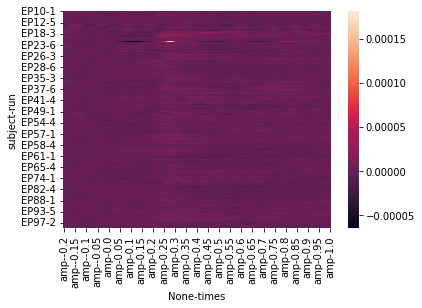

In [11]:
df = eeg_signals_xr.sel(event_id=event_id, ch_name=ch_name, kind="original").to_dataframe().reset_index()
sns.heatmap(df.pivot_table(columns="times", index=["subject", "run"]))

/var/folders/3k/220tdhsn33709gq9ylr8c6kh0000gp/T/ipykernel_70937/643027891.py:2: FutureWarning: pivot_table dropped a column because it failed to aggregate. This behavior is deprecated and will raise in a future version of pandas. Select only the columns that can be aggregated.
  sns.heatmap(df.pivot_table(columns="times", index=["subject", "run"]))


<Axes: xlabel='None-times', ylabel='subject-run'>

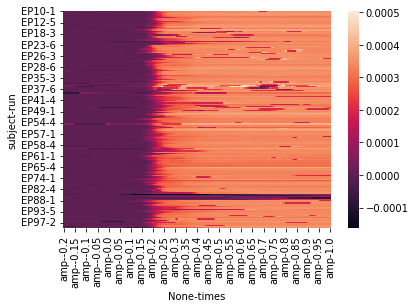

In [12]:
df = et_signals_xr.sel(event_id=event_id, ch_name="eye-x").to_dataframe().reset_index()
sns.heatmap(df.pivot_table(columns="times", index=["subject", "run"]))

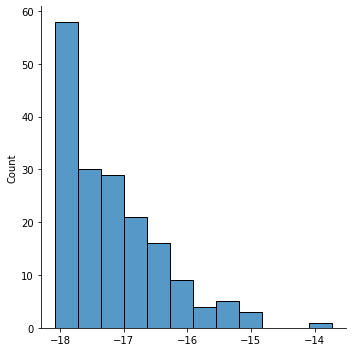

In [13]:
tmp = eeg_signals_xr.sel(event_id=event_id, kind="clean-ica").to_dataframe().reset_index()
tmp = tmp.pivot_table(columns="times", index=["subject", "run"], values="amp")

sns.displot(np.log10(((tmp - tmp.mean(axis=0))**2).sum(axis=1)))

/var/folders/3k/220tdhsn33709gq9ylr8c6kh0000gp/T/ipykernel_70937/3057176588.py:32: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


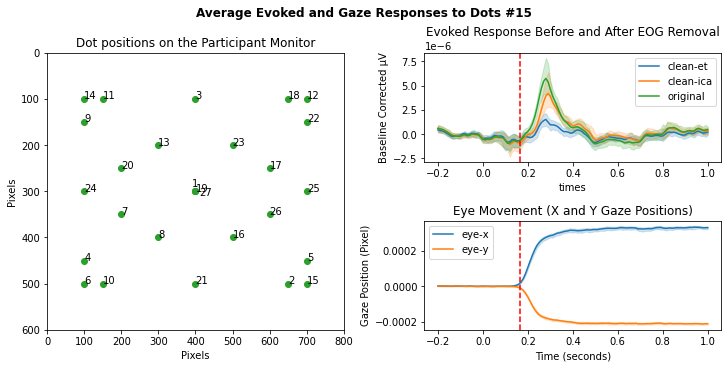

In [14]:

cond = (eeg_signals_df.event_id == event_id) & (eeg_signals_df.ch_name == "E12")

fig = plt.figure(layout="constrained", figsize=(10, 5))
fig.suptitle(f"Average Evoked and Gaze Responses to Dots #{event_id}", fontweight='bold')

ax_dict = fig.subplot_mosaic(
    [
        ["dots", "evoked"],
        ["dots", "gaze"],
    ],
)


plot_dot_fig(ax_dict["dots"])

g = sns.lineplot(data=eeg_signals_xr.sel(event_id=event_id, ch_name=ch_name).to_dataframe(), 
                 x="times", hue="kind", y="amp", ax=ax_dict["evoked"], n_boot=100)
g.legend_.set_title(None)
ax_dict["evoked"].set_title("Evoked Response Before and After EOG Removal")
ax_dict["evoked"].set_ylabel("Baseline Corrected µV")
ax_dict["evoked"].axvline(x=snr_xr["rt"].mean(), linestyle="dashed", color="r")

g = sns.lineplot(data=et_signals_xr.sel(event_id=event_id).to_dataframe(), 
                 x="times", hue="ch_name", y="amp", 
                 ax=ax_dict["gaze"], n_boot=100)
g.legend_.set_title(None)
ax_dict["gaze"].set_xlabel("Time (seconds)")
ax_dict["gaze"].set_ylabel("Gaze Position (Pixel)")
ax_dict["gaze"].set_title("Eye Movement (X and Y Gaze Positions)")
ax_dict["gaze"].axvline(x=snr_xr["rt"].mean(), linestyle="dashed", color="r")

fig.show()

Text(0.5, 0, 'SNR post-RT (lower -> more sensitive)')

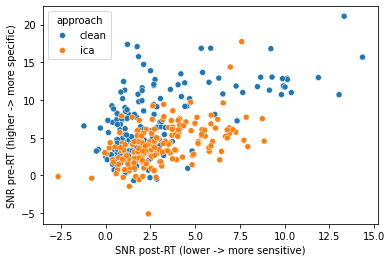

In [15]:
tmp = snr_xr.sel(ch_name=ch_name,  event_id=event_id).to_dataframe().reset_index()
tmp = tmp.pivot_table(columns="condition", index=["approach", "subject", "run"], values="snr").reset_index()
g = sns.scatterplot(x=tmp.post, y=tmp.pre, hue=tmp.approach)
g.axes.set_ylabel("SNR pre-RT (higher -> more specific)")
g.axes.set_xlabel("SNR post-RT (lower -> more sensitive)")


In [16]:
"""tmp = snr_df.drop(columns=["rt"]).pivot_table(index=["approach", "run", "subject"], values="snr", columns="condition").reset_index()
k = 0.5
tmp["pre"] = 1/(1+np.exp(-k*tmp["pre"]))
tmp["post"] = 1/(1+np.exp(-k*tmp["post"]))
g = sns.scatterplot(data=tmp, x="post", y="pre", hue="approach")
g.axes.set_ylabel("SNR pre-RT (high means more specific)")
g.axes.set_xlabel("SNR post-RT (low means more sensitive)")
g.axes.set_xlim(0, 1)
g.axes.set_ylim(0, 1)""";


/var/folders/3k/220tdhsn33709gq9ylr8c6kh0000gp/T/ipykernel_70937/3450891159.py:90: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show()
/var/folders/3k/220tdhsn33709gq9ylr8c6kh0000gp/T/ipykernel_70937/3450891159.py:90: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show()
/var/folders/3k/220tdhsn33709gq9ylr8c6kh0000gp/T/ipykernel_70937/3450891159.py:90: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show()
/var/folders/3k/220tdhsn33709gq9ylr8c6kh0000gp/T/ipykernel_70937/3450891159.py:90: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show()
/var/folders/3k/220tdhsn33709gq9ylr8c6kh0000gp/T/ipykernel_70937/3450891159.py:90: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show()
/var/folders/3k/220tdhsn33709gq9ylr8c6kh0000gp/T/ipykernel_70937/3450891159.py:90: UserWarning: FigureCan

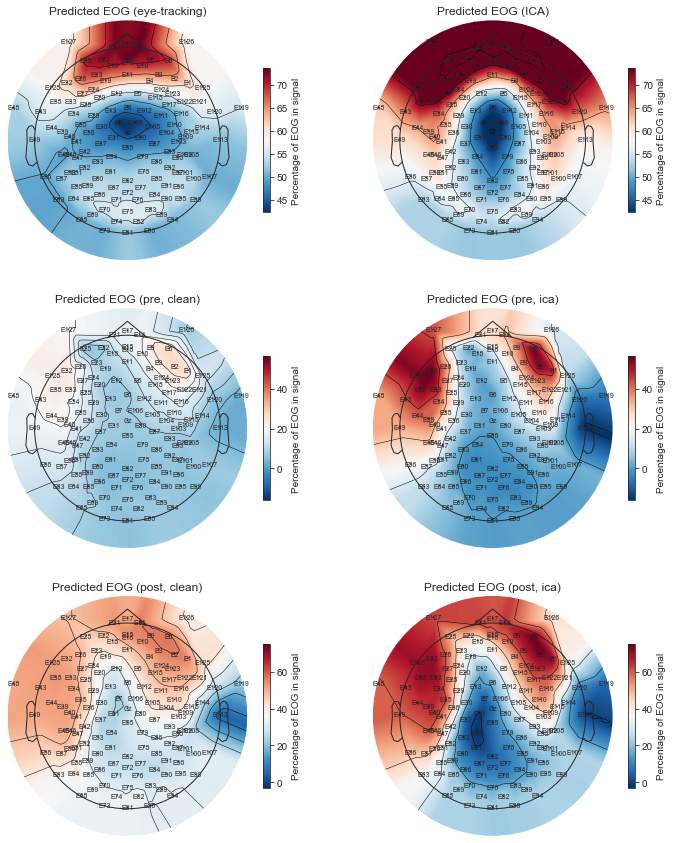

In [17]:
sns.set_style("white")
fig, axes = plt.subplots(3, 2, figsize=(12, 15))

for ax, kind in zip(axes[0], topo_df):
    data_dict = topo_df[kind].iloc[:, :129].mean()
    plot_values_topomap(data_dict,
                        montage, ax, colorbar=True, cmap='RdBu_r',
                            vmin=topo_df["clean"].iloc[:, :129].mean().min(),
                            vmax=topo_df["clean"].iloc[:, :129].mean().max(),
                            names=None, image_interp='linear',
                            sensors=True)
axes[0, 0].set_title("Predicted EOG (eye-tracking)")
axes[0, 1].set_title("Predicted EOG (ICA)")


event_id = "15"
for ax_row, condition in zip(axes[1:], ["pre", "post"]):
    tmp = {"clean": topo_ev_df[(condition, "clean")][topo_ev_df[(condition, "clean")].event_id == event_id].iloc[:, :129],
           "ica": topo_ev_df[(condition, "ica")][topo_ev_df[(condition, "ica")].event_id == event_id].iloc[:, :129]}
    for ax, kind in zip(ax_row, topo_df):
        data_dict = tmp[kind].mean()
        plot_values_topomap(data_dict,
                            montage, ax, colorbar=True, cmap='RdBu_r',
                                vmin=min(tmp["clean"].mean().min(),
                                         tmp["ica"].mean().min()),
                                vmax=max(tmp["clean"].mean().max(),
                                         tmp["ica"].mean().max()),
                                names=None, image_interp='linear',
                                sensors=True)
        ax.set_title(f"Predicted EOG ({condition}, {kind})")



In [315]:
topo_ev_df[(condition, "clean")]

,E1,E2,E3,E4,E5,E6,E7,E8,E9,E10,...,E121,E122,E123,E124,E125,E126,E127,E128,Cz,event_id
0,-49.912430,-28.976574,12.563928,18.766386,16.275530,19.730178,25.254427,32.706057,57.286290,54.230709,...,-8.677483,5.312145,-17.258722,3.624418,-14.217801,21.354402,41.367233,49.699755,33.224022,1
0,30.368956,47.014542,49.539446,56.209395,48.908112,28.719639,11.972324,50.021160,46.384448,52.746729,...,-1.514449,30.628017,40.539875,52.619984,29.360291,22.574431,34.765648,16.544547,13.566114,2
0,44.414777,56.177519,38.957625,35.161830,47.917781,46.689991,45.876065,46.237890,34.237330,33.003351,...,54.413612,53.309921,33.604314,24.396770,53.590561,53.064072,26.746403,-38.979492,46.410766,3
0,65.881643,67.100373,49.805193,38.802396,23.890287,32.794270,25.922848,59.158446,41.858857,30.934748,...,66.657150,65.804488,58.897053,46.411601,66.985583,61.332620,42.613043,49.699610,25.322084,4
0,36.065013,48.217129,59.215102,47.909777,34.649848,19.442123,14.688467,58.760804,63.007933,55.771723,...,22.761780,40.285009,51.217670,46.818203,12.389202,-1.923844,55.825363,30.101046,28.583484,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,-1.612875,3.250229,0.826841,-0.900778,-9.420771,6.266060,-3.131828,0.776636,12.663277,5.531644,...,2.827670,-2.540733,3.614430,5.525923,11.029521,0.776606,8.935565,9.614116,51.912732,23
0,6.148424,0.775513,6.076828,1.909392,0.440483,0.077911,-1.847966,5.714087,2.137194,-6.192654,...,1.132479,9.873778,1.690208,3.461478,6.209810,8.228573,6.706143,-9.363175,53.474826,24
0,2.920356,-2.199744,8.619203,-2.686899,3.075083,4.462162,-7.062194,1.780180,-2.743084,1.961180,...,-1.727606,4.333768,0.211616,-0.730959,-0.067615,2.510994,7.692622,11.705993,41.489861,25
0,8.185327,15.093117,9.021033,-5.280672,10.185359,3.921664,-3.644199,-0.387652,-0.123278,1.565743,...,-1.555290,3.400771,6.014107,18.805431,11.072473,5.307498,0.415036,6.870884,31.015211,26


In [ ]:
# Standard lib
from pathlib import Path

# Scientific Stack
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ML/DL Stack
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.nn.functional as F # for easy use of relu


# File I/O, Signal Processing
import mne
import eoglearn  # This is my package for this project
import pymatreader

In [ ]:
sns.set_style("darkgrid")

# Model

In [ ]:
class EOGRegressor(nn.Module):
    def __init__(self, n_input_features, n_output_features, hidden_size=64, num_layers=1, dropout=0.5):
        super(EOGRegressor, self).__init__()
        self.input_size = n_input_features
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout = nn.Dropout(dropout)

        self.rnn = nn.LSTM(n_input_features, hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, n_output_features)

    def forward(self, input):
        # input shape: (batch_size, seq_len, input_size)
        batch_size = input.size(0)  # same as input.shape[0]

        # Initialize hidden state & cell states
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size)

        # Forward propagate RNN
        out, (h0, c0) = self.rnn(input, (h0, c0))

        # Decode the hidden state of the last time step
        out = self.dropout(out)
        out = self.fc(out)

        return out

def train_the_model(X, Y, num_epochs=1000, hidden_size=64, num_layers=1, dropout=0.5):
    """ Train the Pytorch model."""

    # Instantiate the model
    if X.ndim == 3:
        assert Y.ndim == 3
        input_features = X.shape[2]  # Assuming (batch_size, seq_len, input_size)
        output_features = Y.shape[2]
    else:
        raise ValueError("Input data must have 3 dimensions: (batch_size, seq_len, input_size)")

    model = EOGRegressor(input_features, output_features, hidden_size=hidden_size, num_layers=num_layers, dropout=dropout)

    # Loss function (Mean Squared Error)
    criterion = nn.MSELoss()

    # Optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

    losses = np.zeros(num_epochs)
    # Training loop
    model.train()
    for i, epoch in enumerate(range(num_epochs)):
        # Forward pass
        outputs = model(X)

        # Compute loss
        loss = criterion(outputs, Y)
        losses[i] = loss.detach().numpy()

        # Zero gradients, backward pass, and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print the loss every 100 iterations
        if i % 100 == 0:
            print(f'Epoch: {epoch} Loss: {loss.item():.4f}')

    # Set model to eval mode to turn off dropout
    model.eval()
    with torch.no_grad():
        predicted_noise = model(X)
        denoised_output = (Y - predicted_noise).numpy()

    return losses, predicted_noise, denoised_output

# Prep Data

In [ ]:
def prep_data(subject="EP10", run=1):
  fpath = eoglearn.datasets.fetch_eegeyenet(subject=subject, run=run)
  raw = eoglearn.io.read_raw_eegeyenet(fpath)

  raw.set_montage("GSN-HydroCel-129")
  raw.filter(1, 30, picks="eeg").resample(100)  # DO NOT filter eyetrack channels
  raw.set_eeg_reference("average")
  return raw

def format_data_for_ml(raw, tmax):
  # normalize the dataset
  X = raw.get_data(picks=["eyetrack"]).T #[::5] # decimate the eyetracking data

  Y = raw.get_data(picks="eeg").T

  scaler = StandardScaler()
  X = scaler.fit_transform(X)
  # For Y we need to split the fit and transform into 2 steps
  # Because we will need to inverse transform the model output later during evaluation
  scaler = StandardScaler()
  scaler_y = scaler.fit(Y)
  Y = scaler_y.transform(Y)

  # 1s epochs
  X = X.reshape(tmax, int(raw.info["sfreq"]), 3)
  Y = Y.reshape(tmax, int(raw.info["sfreq"]), 129)

  # Convert data to tensors
  X_tensor = torch.from_numpy(X).float()
  Y_tensor = torch.from_numpy(Y).float()

  return X_tensor, Y_tensor, scaler_y


### Demo Toy: crop to 300-seconds

In [ ]:
def clean_data(subject, run, tmax=None):

  raw = prep_data(subject="EP10", run=1)

  if tmax is None:
    tmax = int(raw.times[-1])
  raw.crop(tmax=tmax, include_tmax=False)

  X_tensor, Y_tensor, scaler_y = format_data_for_ml(raw, tmax)
  losses, predicted_noise, denoised_output = train_the_model(X_tensor, Y_tensor, dropout=.5, num_layers=2)

  # Reshape back to 2D and inverse transform to original units (Volts)
  predicted_noise = scaler_y.inverse_transform(predicted_noise.reshape(tmax*int(raw.info['sfreq']), 129)).T
  denoised_output = scaler_y.inverse_transform(denoised_output.reshape(tmax*int(raw.info['sfreq']), 129)).T

  raw_clean = mne.io.RawArray(denoised_output, raw.copy().pick("eeg").info)
  raw_noise = mne.io.RawArray(predicted_noise, raw.copy().pick("eeg").info)
  return raw, raw_clean, raw_noise

In [ ]:
runs_dict = eoglearn.datasets.eegeyenet.get_subjects_runs()
runs_dict

{'EP10': array([1, 2, 3, 4, 5, 6]),
 'EP12': array([1, 2, 3, 4, 5, 6]),
 'EP14': array([2, 3, 4, 5, 6]),
 'EP18': array([1, 2, 3, 4, 5, 6]),
 'EP23': array([1, 2, 3, 4, 5, 6]),
 'EP24': array([1, 2, 3, 4, 5, 6]),
 'EP26': array([1, 2, 3, 4, 5, 6]),
 'EP28': array([1, 2, 3, 4, 5, 6]),
 'EP29': array([1, 2, 3, 4, 5, 6]),
 'EP35': array([1, 2, 3, 4, 5, 6]),
 'EP37': array([1, 2, 3, 4, 5, 6]),
 'EP39': array([1, 2, 3, 4, 5, 6]),
 'EP41': array([1, 2, 4, 5, 6]),
 'EP46': array([1, 2, 3, 4, 5, 6]),
 'EP49': array([1, 2, 3, 4, 5, 6]),
 'EP54': array([1, 2, 3, 4, 5, 6]),
 'EP56': array([1, 2, 3, 4, 5, 6]),
 'EP57': array([1, 2, 3, 4, 5, 6]),
 'EP58': array([1, 2, 3, 4, 5, 6]),
 'EP59': array([1, 2, 3, 4, 5, 6]),
 'EP61': array([1, 2, 3, 4, 5, 6]),
 'EP65': array([1, 2, 3, 4, 5, 6]),
 'EP72': array([1, 2, 3, 4, 5, 6]),
 'EP74': array([1, 2, 3, 4, 5, 6]),
 'EP82': array([1, 2, 3, 4, 5, 6]),
 'EP86': array([1, 2, 3, 4, 5, 6]),
 'EP88': array([1, 2, 3, 4, 5]),
 'EP93': array([1, 2, 3, 4, 5, 6]),
 

In [ ]:
plot_picks = np.arange(24, 35)

raw_clean.plot(order=plot_picks)

In [ ]:
raw_noise.plot(order=plot_picks)

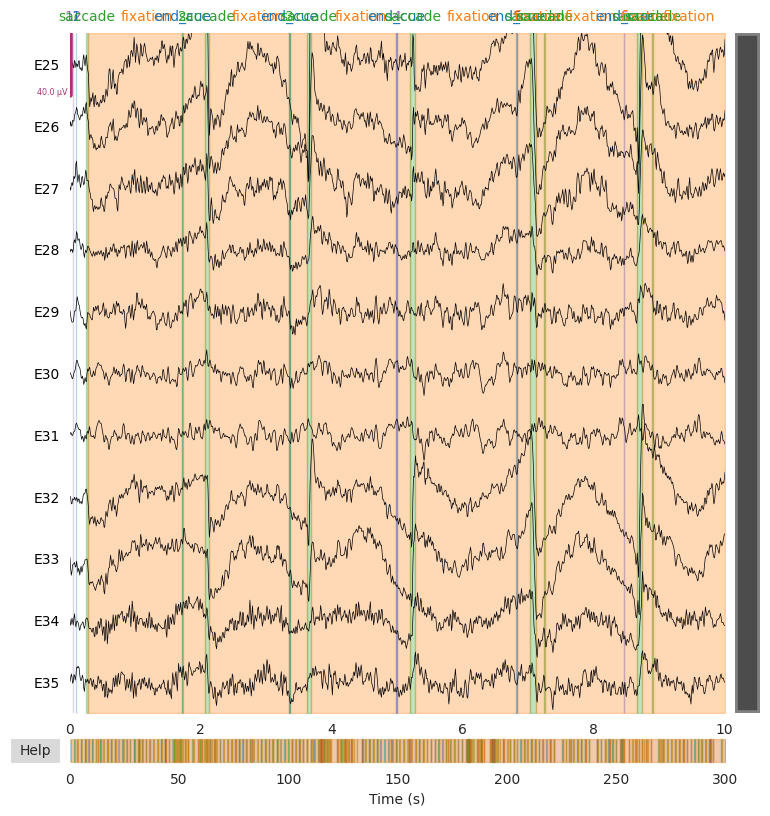

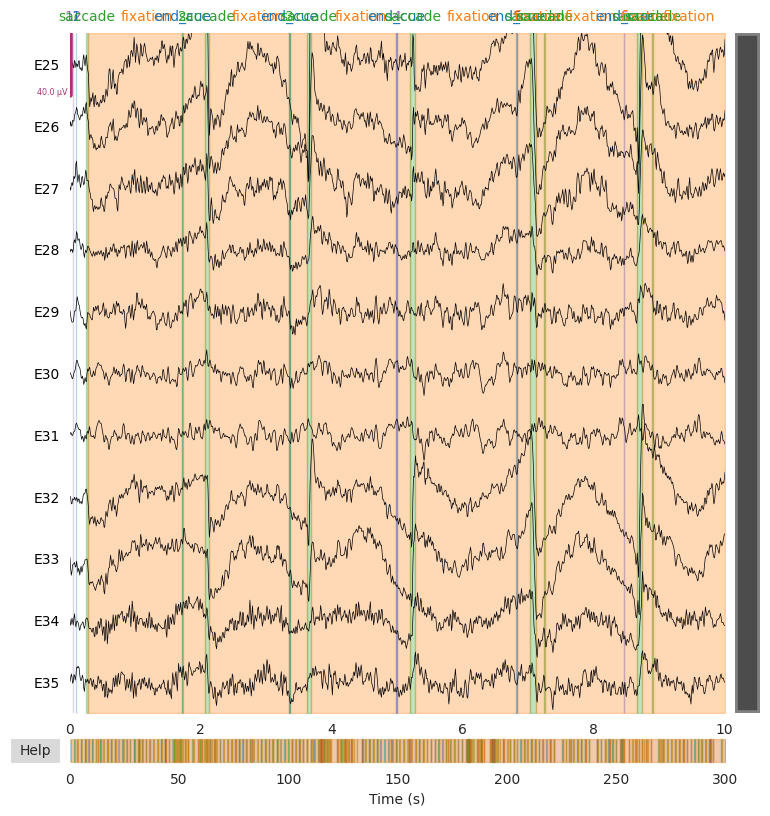

In [ ]:
raw.plot(order=plot_picks)

Used Annotations descriptions: ['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '3', '4', '5', '6', '7', '8', '9']
Not setting metadata
125 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 125 events and 121 original time points ...
21 bad epochs dropped


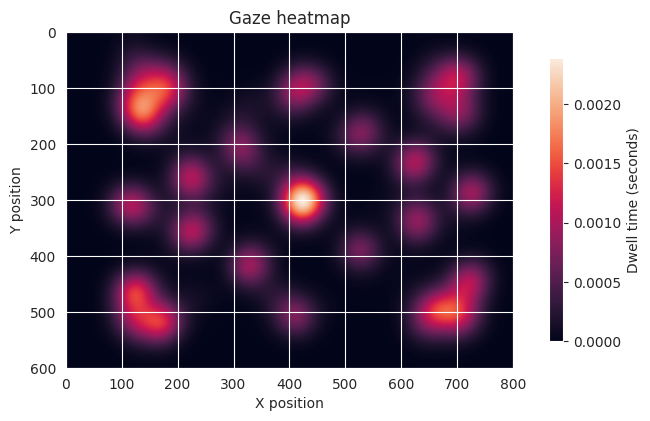

Not setting metadata
125 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 125 events and 121 original time points ...
21 bad epochs dropped
Not setting metadata
125 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 125 events and 121 original time points ...
3 bad epochs dropped
Not setting metadata
125 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 125 events and 121 original time points ...
21 bad epochs dropped


In [ ]:
from mne.io import BaseRaw

frontal = ["E19", "E11", "E4", "E12", "E5"]
#frontal = ["E19", "E11", "E4", "E12", "E5", "E24", "E124"]
#frontal = ["E8", "E9", "E15", "E22", "E25", "E1", "E2", "E3", "E10", "E16", "E18", "E23", "E26"]
events, _ = mne.events_from_annotations(raw, regexp="^[0-9]*$")

def get_epochs(raw, events, baseline=(None, 0)):
  # this applies a baseline to the eyegaze channels which we dont generally want but okay for now i think
  return mne.Epochs(raw, events, tmin=-.2, tmax=1, preload=True, baseline=baseline)

def get_evoked(inst, picks, events=None, baseline=(None, 0)):
  # see https://eoglearn.readthedocs.io/en/latest/auto_examples/plot_eegeyenet.html#sphx-glr-auto-examples-plot-eegeyenet-py
  # for stimuli locations
  if isinstance(inst, BaseRaw):
    assert events is not None, "Must pass in an events array to get evoked from Raw."
    inst = get_epochs(inst, events, baseline=baseline)
  return inst["2", "5", "15"].average().copy().pick(picks)


gaze = get_epochs(raw, events, baseline=None)
gaze = gaze.pick("eyegaze")
mne.viz.eyetracking.plot_gaze(gaze, width=800, height=600)

evoked = get_evoked(raw, frontal, events)
ev = evoked.get_data()
evoked_clean = get_evoked(raw_clean,frontal, events)
ev_clean = evoked_clean.get_data()

evoked_eye = get_evoked(raw, "eyegaze", events)
ev_eye = evoked_eye.get_data()

# ICA & ICLABEL

In [ ]:
%pip install mne-icalabel --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.6/21.6 MB 31.5 MB/s eta 0:00:00


In [ ]:
import mne_icalabel

# reload raw and bandpass 1-100 to be fair to ICLabel
raw_ica = eoglearn.io.read_raw_eegeyenet(fname)
raw_ica.set_montage("GSN-HydroCel-129")
raw_ica.set_eeg_reference("average")
raw_ica.set_annotations(None) # get rid of BAD_blinks annots
raw_ica.pick("eeg").filter(1, 100).resample(100)
raw_ica.crop(tmax=300, include_tmax=False)

# epochs_ica = get_epochs(raw_ica, events, baseline=None)

ica = mne.preprocessing.ICA(method="infomax", fit_params=dict(extended=True))
ica.fit(raw_ica)
component_dict = mne_icalabel.label_components(raw_ica, ica, "iclabel")

exclude_idx = [idx for idx, label in enumerate(component_dict["labels"]) if label in ["eye blink"]]

# Now apply the ICA to raw, lowpass to 30Hz to match our DL Raw, and plot.
ica.apply(raw_ica, exclude=exclude_idx)
raw_ica.filter(None, 30)

epochs_ica = get_epochs(raw_ica, events)
evoked_ica = get_evoked(raw_ica, frontal, events)
ev_ica = evoked_ica.get_data()

Creating RawArray with float64 data, n_channels=133, n_times=161733
    Range : 0 ... 161732 =      0.000 ...   323.464 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 1651 samples (3.302 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    1.0s


Fitting ICA to data using 129 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 96 components
Computing Extended Infomax ICA
Fitting ICA took 123.3s.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


<ipython-input-20-65cb88df9fe4>:15: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  component_dict = mne_icalabel.label_components(raw_ica, ica, "iclabel")


Applying ICA to Raw instance
    Transforming to ICA space (96 components)
    Zeroing out 3 ICA components
    Projecting back using 129 PCA components
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.4s


Not setting metadata
125 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 125 events and 121 original time points ...
3 bad epochs dropped
Not setting metadata
125 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 125 events and 121 original time points ...
3 bad epochs dropped


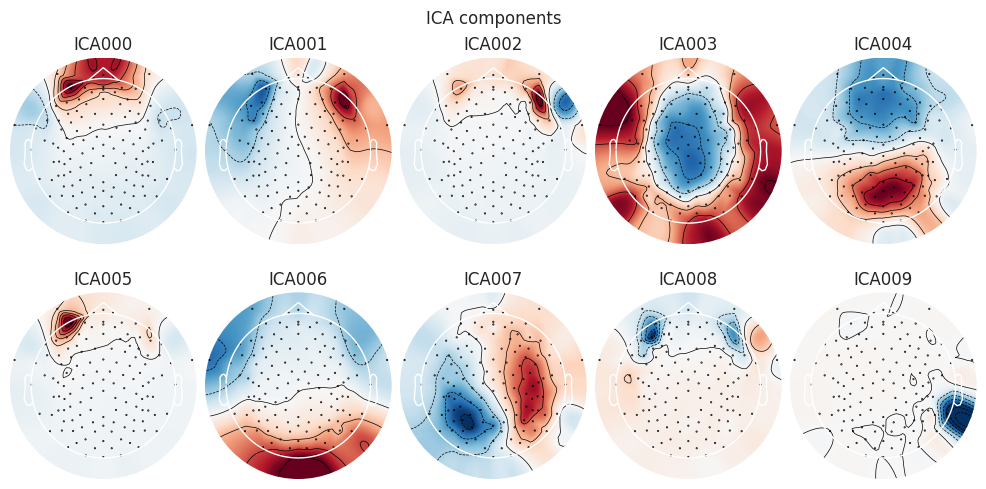

In [ ]:
ica.plot_components(picks=slice(0, 10), inst=epochs_ica);

In [ ]:
exclude_idx

[0, 1, 8]

# Plot the Target Positions & Evoked Responses

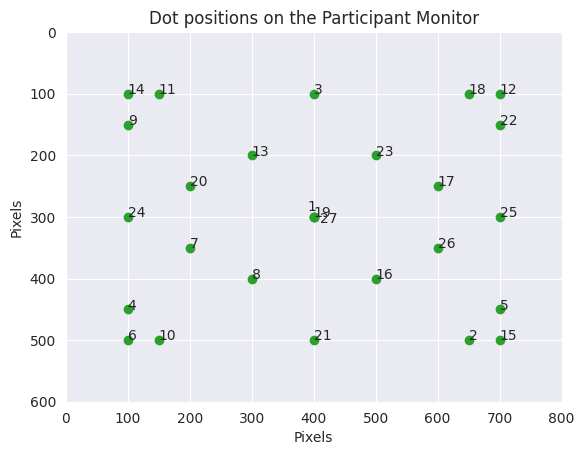

In [ ]:
target_positions = eoglearn.io.get_dot_positions()

fig, ax = plt.subplots()
for trigger, position in target_positions.items():
    ax.scatter(*position, color=sns.color_palette()[2])
    xy = (
        position - 10
        if trigger == "1"
        else position + 10
        if trigger == "27"
        else position
    )
    ax.text(*xy, trigger)

ax.set_ylim(0, 600)
ax.set_xlim(0, 800)
ax.invert_yaxis()
ax.set_xlabel("Pixels")
ax.set_ylabel("Pixels")
ax.set_title("Dot positions on the Participant Monitor")
fig.show()

# Let's Check an evoked response..

Text(0.5, 1.0, 'Average X and Y Gaze Positions During Trials')

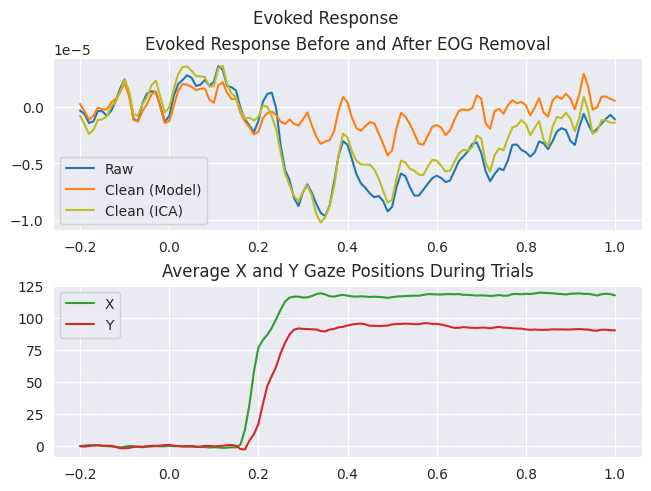

In [ ]:
fig, ax = plt.subplots(2, 1, constrained_layout=True)
fig.suptitle("Evoked Response")

ax[0].plot(evoked.times, ev.mean(0), label="Raw")
ax[0].plot(evoked.times, ev_clean.mean(0), label="Clean (Model)")
ax[0].plot(evoked.times, ev_ica.mean(0), label="Clean (ICA)", color=sns.color_palette()[8])
ax[0].legend()
ax[0].set_title("Evoked Response Before and After EOG Removal")
ax[1].plot(evoked.times, ev_eye[0], label="X", color=sns.color_palette()[2])
ax[1].plot(evoked.times, ev_eye[1], label="Y", color=sns.color_palette()[3])
ax[1].legend()
ax[1].set_title("Average X and Y Gaze Positions During Trials")

specificity (pre-RT distorsion): ICA=4.44dB; ET=3.78dB


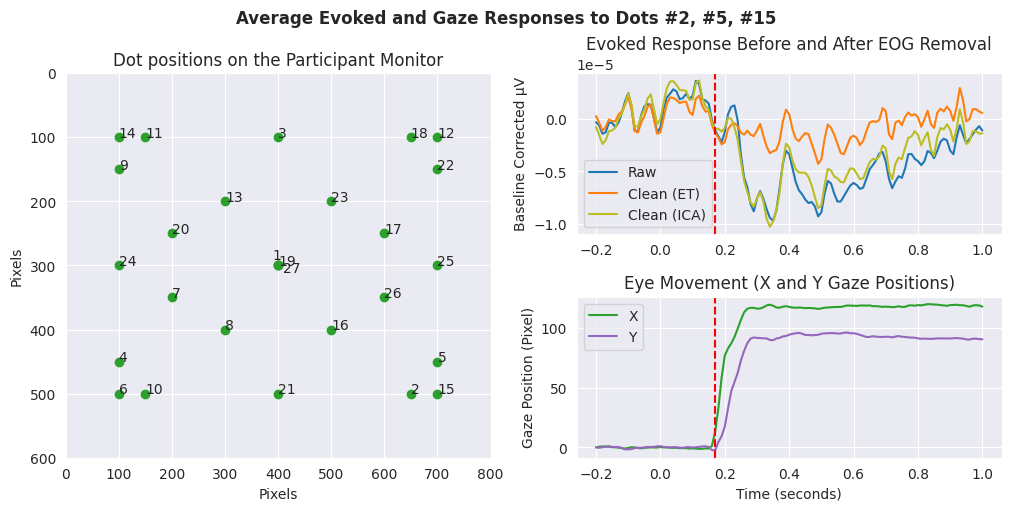

In [ ]:
def rms(x):
  return np.sqrt(np.mean(x**2))

fig = plt.figure(layout="constrained", figsize=(10, 5))
fig.suptitle("Average Evoked and Gaze Responses to Dots #2, #5, #15", fontweight='bold')


ax_dict = fig.subplot_mosaic(
    [
        ["dots", "evoked"],
        ["dots", "gaze"],
    ],
)


#reaction time
r = np.sqrt(ev_eye[0]**2 + ev_eye[1]**2)
rt = evoked.times[r > 0.05*r.max()][0]

signal = rms(ev.mean(0)[evoked.times < rt])
noise_et = rms((ev.mean(0) - ev_clean.mean(0))[evoked.times < rt])
noise_ica = rms((ev.mean(0) - ev_ica.mean(0))[evoked.times < rt])

snr_et = 10*np.log10(signal/noise_et)
snr_ica = 10*np.log10(signal/noise_ica)

print(f"specificity (pre-RT distorsion): ICA={snr_ica:.2f}dB; ET={snr_et:.2f}dB")

target_positions = eoglearn.io.get_dot_positions()
for trigger, position in target_positions.items():
    ax_dict["dots"].scatter(*position, color=sns.color_palette()[2])
    xy = (
        position - 10
        if trigger == "1"
        else position + 10
        if trigger == "27"
        else position
    )
    ax_dict["dots"].text(*xy, trigger)

ax_dict["dots"].set_ylim(0, 600)
ax_dict["dots"].set_xlim(0, 800)
ax_dict["dots"].invert_yaxis()
ax_dict["dots"].set_xlabel("Pixels")
ax_dict["dots"].set_ylabel("Pixels")
ax_dict["dots"].set_title("Dot positions on the Participant Monitor")

ax_dict["evoked"].plot(evoked.times, ev.mean(0), label="Raw")
ax_dict["evoked"].plot(evoked.times, ev_clean.mean(0), label="Clean (ET)")
ax_dict["evoked"].plot(evoked.times, ev_ica.mean(0), label="Clean (ICA)", color=sns.color_palette()[8])
ax_dict["evoked"].legend()
ax_dict["evoked"].set_title("Evoked Response Before and After EOG Removal")
ax_dict["evoked"].set_ylabel("Baseline Corrected µV")
ax_dict["evoked"].axvline(x=rt, linestyle="dashed", color="r")

ax_dict["gaze"].plot(evoked.times, ev_eye[0], label="X", color=sns.color_palette()[2])
ax_dict["gaze"].plot(evoked.times, ev_eye[1], label="Y", color=sns.color_palette()[4])
ax_dict["gaze"].axvline(x=rt, linestyle="dashed", color="r")
ax_dict["gaze"].legend()
ax_dict["gaze"].set_xlabel("Time (seconds)")
ax_dict["gaze"].set_ylabel("Gaze Position (Pixel)")
ax_dict["gaze"].set_title("Eye Movement (X and Y Gaze Positions)")

fig.show()

# Plot a Topomap of the predicted Noise

In [ ]:
import warnings


def plot_values_topomap(
    value_dict,
    montage,
    axes=None,
    colorbar=True,
    cmap="RdBu_r",
    vmin=None,
    vmax=None,
    names=None,
    image_interp="bilinear",
    sensors=True,
    show=True,
    **kwargs
):
    """Plot a 2D topographic map of EEG data.

    Parameters
    ----------
    value_dict : dict
        a dict containing EEG sensor names as keys, and a scalar value as values.
        The value is subject to what is to be plotted. (For example, it can be an
        EEG power value for each sensor, or an ICA activation for each sensor).
    montage : mne.channels.DigMontage | str
        Montage for digitized electrode and headshape position data.
        See mne.channels.make_standard_montage(), and
        mne.channels.get_builtin_montages() for more information
        on making montage objects in MNE.
    axes : matplotlib.axes
        The axes object to plot on
    colorbar | bool
        if True, show the corresponding colorbar for z values
    cmap : matplotlib colormap | str | None
        The matplotlib colormap to use. Defaults to 'RdBu_r'
    vmin : float | None
        The minimum value for the colormap. If ``None``, the minimum value is
        set to the minimum value of the heatmap. Default is ``None``.
    vmax : float | None
        The maximum value for the colormap. If ``None``, the maximum value is
        set to the maximum value of the heatmap. Default is ``None``.
    image_interp : str
        The interpolation method to use with matplotlib.imshow. Defaults to
        'bilinear'
    sensors : bool
        Whether to plot black dots on the topoplot, representing the EEG sensor
        positions. Defaults to True.
    show : bool
        Whether to show the plot or not. Defaults to True.
    kwargs : dict
        Valid keyword arguments for mne.viz.plot_topomap

    Returns
    -------
    fig : instance of matplotlib.figure.Figure
      The resulting figure object for the heatmap plot
    """
    if names is None:
        names = [ch for ch in montage.ch_names if ch in value_dict]

    info = mne.create_info(names, sfreq=256, ch_types="eeg")
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        mne.io.RawArray(
            np.zeros((len(names), 1)), info, copy=None, verbose=False
        ).set_montage(montage)

    if axes:
        ax = axes
        fig = ax.figure
    else:
        fig, ax = plt.subplots(constrained_layout=True)
    im = mne.viz.plot_topomap(
        [value_dict[ch] for ch in names],
        pos=info,
        show=False,
        image_interp=image_interp,
        sensors=sensors,
        res=64,
        axes=ax,
        names=names,
        vlim=[vmin, vmax],
        cmap=cmap,
        **kwargs
    )

    if colorbar:
        fig.colorbar(im[0], ax=axes, shrink=0.6, label="Percentage of EOG in signal")
    (fig or plt).show()
    return fig

In [ ]:
sns.set_style("white")
fig, ax = plt.subplots()

montage = mne.channels.make_standard_montage('GSN-HydroCel-129')
eeg_names = raw.copy().pick("eeg").ch_names


noise = np.sqrt(np.mean(np.square(denoised_output), axis=1))
# original EEG data, reshaped back to 2D and root mean square (average is across time)
signal = np.sqrt(np.mean(np.square(scaler_y.inverse_transform(Y_tensor.numpy().reshape(30_000, 129)).T), axis=1))

nsr = noise / signal
percent_noise = 1 - nsr
percent_noise *= 100

data_dict = dict(list(zip(eeg_names, percent_noise)))
plot_values_topomap(data_dict,
                    montage, ax, colorbar=True, cmap='RdBu_r',
                        vmin=percent_noise.min(),
                        vmax=percent_noise.max(),
                        names=None, image_interp='linear',
                        sensors=True)
ax.set_title("Topographic representation of Predicted EOG")

In [ ]:
fig, ax = plt.subplots()

montage = mne.channels.make_standard_montage('GSN-HydroCel-129')
eeg_names = raw.copy().pick("eeg").ch_names


noise = np.sqrt(np.mean(np.square(denoised_output), axis=1))
# original EEG data, reshaped back to 2D and root mean square (average is across time)
signal = np.sqrt(np.mean(np.square(scaler_y.inverse_transform(Y_tensor.numpy().reshape(30_000, 129)).T), axis=1))

nsr = noise / signal
percent_noise = 1 - nsr
percent_noise *= 100

data_dict = dict(list(zip(eeg_names, percent_noise)))
plot_values_topomap(data_dict,
                    montage, ax, colorbar=True, cmap='RdBu_r',
                        vmin=percent_noise.min(),
                        vmax=percent_noise.max(),
                        names=None, image_interp='linear',
                        sensors=True)
ax.set_title("Topographic representation of Predicted Noise")

# Try our Tensorflow LSTM

In [ ]:
X.shape, Y.shape

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, LSTM

model = Sequential()

# LSTM layer accepts a 3D array as input which has a shape of (n_sample, n_timesteps, n_features)
model.add(LSTM(300, input_shape=(100, 3), return_sequences=True))  # see X.shape
model.add(Dropout(0.5))
model.add(LSTM(129, return_sequences=True))  # see Y.shape
model.add(Dropout(0.5))

optifun = tf.keras.optimizers.Adagrad(learning_rate=1)
model.compile(loss='mean_squared_error', optimizer=optifun)

model.fit(X, Y, epochs=50, validation_split=0.2, batch_size=1, verbose=2)
predictions = model.predict(X) # predicted EOG artifact

In [ ]:
# Reshape back to 2D
predicted_eog = scaler_y.inverse_transform(predictions.reshape(6_000, 129)).T
denoised_eeg = scaler_y.inverse_transform(Y.reshape(6_000, 129)).T - predicted_eog

In [ ]:
raw_clean = mne.io.RawArray(denoised_eeg, raw.copy().pick("eeg").info)
raw_noise = mne.io.RawArray(predicted_eog, raw.copy().pick("eeg").info)

In [ ]:
raw_clean.plot(order=plot_picks)

In [ ]:
raw_noise.plot(order=plot_picks)

In [ ]:
fig, ax = plt.subplots()

noise = np.sqrt(np.mean(np.square(predicted_eog), axis=1))
signal = np.sqrt(np.mean(np.square(scaler_y.inverse_transform(Y.reshape(6_000, 129)).T), axis=1))

nsr = noise / signal
#percent_noise = 1 - nsr
#percent_noise *= 100

data_dict = dict(list(zip(eeg_names, nsr)))
plot_values_topomap(data_dict,
                    montage, ax, colorbar=True, cmap='RdBu_r',
                        vmin=nsr.min(),
                        vmax=nsr.max(),
                        names=None, image_interp='linear',
                        sensors=True)
ax.set_title("Topographic representation of Predicted Noise")

# Try try two stacked RNN layers (I think this closer matches the original TF model). Also try to add batch normalization.

In [ ]:
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1, dropout=0.5, rnn_class="LSTM"):
        super(RNNModel, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        self.dropout = dropout

        RNNCLass = getattr(torch.nn, rnn_class)
        self.encoder = RNNCLass(input_size, hidden_size, num_layers, dropout=dropout, batch_first=True)
        self.decoder = RNNCLass(output_size, hidden_size, num_layers, dropout=dropout, batch_first=True)
        self.fc_out = nn.Linear(hidden_size, output_size)

    def forward(self, input_seq, target_seq):
        # Encode the input sequence
        _, encoder_hidden = self.encoder(input_seq)

        # Decode the target sequence
        outputs, _ = self.decoder(target_seq, encoder_hidden)

        # Project the outputs to the desired output size
        outputs = self.fc_out(outputs)

        return outputs

model = RNNModel(input_size=3, hidden_size=64, output_size=129, num_layers=2, dropout=.5, rnn_class="LSTM")

optimizer = torch.optim.Adam(model.parameters(), lr=.01)
loss_function = nn.MSELoss()


# Train the model
step = 3 # batch steps
for epoch in range(1000):
    # batches
    for i in range(0, X_tensor.shape[0], step):
        # Get the inputs and outputs
        inputs = X_tensor[i:i+step]
        outputs = Y_tensor[i:i+step]

        # Forward pass
        outputs_pred = model(inputs, outputs)

        # Calculate the loss
        loss = loss_function(outputs_pred, outputs)

        # Backpropagate and update the weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Print the loss every 100 iterations
    if epoch % 100 == 0:
        print(f'Epoch: {epoch} Loss: {loss.item():.4f}')

# Set model to eval mode to turn off dropout
model.eval()
with torch.no_grad():
    predicted_noise = model(X_tensor, Y_tensor)
    denoised_output = (Y_tensor - predicted_noise).numpy()


In [ ]:
predicted_noise = scaler_y.inverse_transform(predicted_noise.numpy().reshape(30_000, 129)).T
denoised_output = scaler_y.inverse_transform(denoised_output.reshape(30_000, 129)).T

In [ ]:
raw_clean = mne.io.RawArray(denoised_output, raw.copy().pick("eeg").info)
raw_clean.plot()

In [ ]:
raw_noise.plot()

# Try the PLR dataset

In [ ]:
raw.copy().pick("eyetrack").plot(scalings=dict(eyegaze=1e3))

In [ ]:
raw.plot()

In [ ]:
fig, ax = plt.subplots()

noise = np.sqrt(np.mean(np.square(predicted_noise), axis=1))

nsr =  noise / signal

data_dict = dict(list(zip(eeg_names, nsr)))
plot_values_topomap(data_dict,
                    montage, ax, colorbar=True, cmap='RdBu_r',
                        vmin=nsr.min(),
                        vmax=nsr.max(),
                        names=None, image_interp='linear',
                        sensors=True)
ax.set_title("Topographic representation of Predicted Noise")

# Try the PLR Dataset

In [ ]:
raw = eoglearn.datasets.read_mne_eyetracking_raw()
# mne.preprocessing.eyetracking.interpolate_blinks(raw, interpolate_gaze=True)
raw.apply_function(lambda x: np.nan_to_num(x), picks="eyetrack")
raw.filter(1, 30, picks="eeg").resample(100).crop(tmax=120, include_tmax=False)

In [ ]:
raw.copy().pick("eyetrack").plot(scalings=dict(eyegaze=1e3))

In [ ]:
scaler = StandardScaler()
scaler_y = StandardScaler()

X = raw.get_data(picks="eyetrack").T
Y = raw.get_data(picks="eeg").T


X = scaler.fit_transform(X)

scaler_y = scaler_y.fit(Y)
Y = scaler_y.transform(Y)


X = X.reshape(120, 100, 3)
Y = Y.reshape(120, 100, 129)


# Convert data to tensors
X_tensor = torch.from_numpy(X).float()
Y_tensor = torch.from_numpy(Y).float()

In [ ]:
X_tensor.shape, Y_tensor.shape

In [ ]:
losses, predicted_noise, denoised_output = train_the_model(X_tensor, Y_tensor, dropout=.2, num_layers=1)

In [ ]:
# Reshape back to 2D
predicted_noise = scaler_y.inverse_transform(predicted_noise.reshape(129, 12_000))
denoised_output = scaler_y.inverse_transform(Y.reshape(129, 12_000)) - predicted_noise

raw_clean = mne.io.RawArray(denoised_output, raw.copy().pick("eeg").info)
raw_noise = mne.io.RawArray(predicted_noise, raw.copy().pick("eeg").info)

In [ ]:
raw_clean.plot()

In [ ]:
raw_noise.plot()

In [ ]:
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1, dropout=0.5, rnn_class="LSTM"):
        super(RNNModel, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        self.dropout = dropout

        RNNCLass = getattr(torch.nn, rnn_class)
        self.encoder = RNNCLass(input_size, hidden_size, num_layers, dropout=dropout, batch_first=True)
        self.decoder = RNNCLass(output_size, hidden_size, num_layers, dropout=dropout, batch_first=True)
        self.fc_out = nn.Linear(hidden_size, output_size)

    def forward(self, input_seq, target_seq):
        # Encode the input sequence
        _, encoder_hidden = self.encoder(input_seq)

        # Decode the target sequence
        outputs, _ = self.decoder(target_seq, encoder_hidden)

        # Project the outputs to the desired output size
        outputs = self.fc_out(outputs)

        return outputs

model = RNNModel(input_size=3, hidden_size=32, output_size=129, num_layers=2, dropout=.2, rnn_class="LSTM")

optimizer = torch.optim.Adam(model.parameters(), lr=.01)
loss_function = nn.MSELoss()


# Train the model
step = 1 # batch steps
for epoch in range(1000):
    # batches
    for i in range(0, X_tensor.shape[0], step):
        # Get the inputs and outputs
        inputs = X_tensor[i:i+step]
        outputs = Y_tensor[i:i+step]

        # Forward pass
        outputs_pred = model(inputs, outputs)

        # Calculate the loss
        loss = loss_function(outputs_pred, outputs)

        # Backpropagate and update the weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Print the loss every 100 iterations
    if epoch % 100 == 0:
        print(f'Epoch: {epoch} Loss: {loss.item():.4f}')

# Set model to eval mode to turn off dropout
model.eval()
with torch.no_grad():
    predicted_noise = model(X_tensor, Y_tensor)
    denoised_output = (Y_tensor - predicted_noise).numpy()


In [ ]:
# Reshape back to 2D
predicted_noise = scaler_y.inverse_transform(predicted_noise.reshape(129, 12_000))
denoised_output = scaler_y.inverse_transform(Y.reshape(129, 12_000)) - predicted_noise

In [ ]:
raw_clean = mne.io.RawArray(denoised_output, raw.copy().pick("eeg").info)
raw_noise = mne.io.RawArray(predicted_noise, raw.copy().pick("eeg").info)

In [ ]:
raw_clean.plot()

In [ ]:
raw_noise.plot()

In [ ]:
raw.plot()

In [ ]:
events, event_id = mne.events_from_annotations(raw, regexp="Flash")

epochs = mne.Epochs(raw, events=events, event_id=event_id, tmin=-0.3, tmax=3, preload=True)
epochs_clean = mne.Epochs(raw_clean, events=events, event_id=event_id, tmin=-0.3, tmax=3, preload=True)
epochs_noise = mne.Epochs(raw_noise, events=events, event_id=event_id, tmin=-0.3, tmax=3, preload=True)


frontal = ["E19", "E11", "E4", "E12", "E5"]
noise_avg_frontal = epochs_noise.average().get_data(picks=frontal).mean(0)
avg_frontal = epochs.average().get_data(picks=frontal).mean(0)

ax = plt.subplot()
ax.plot(epochs_noise.times, noise_avg_frontal, label="predicted")
ax.plot(epochs_noise.times, avg_frontal, label="original")
ax.set_xlim(-0.3, 1)
ax.legend()

# TF

In [ ]:
model = Sequential()

# LSTM layer accepts a 3D array as input which has a shape of (n_sample, n_timesteps, n_features)
model.add(LSTM(50, input_shape=(100, 3), return_sequences=True))  # see X.shape
model.add(Dropout(0.5))
model.add(LSTM(129, return_sequences=True))  # see Y.shape
model.add(Dropout(0.5))

optifun = tf.keras.optimizers.Adagrad(learning_rate=1)
model.compile(loss='mean_squared_error', optimizer=optifun)

model.fit(X_tensor.numpy(), Y_tensor.numpy(), epochs=10, validation_split=0.2, batch_size=1, verbose=2)
predictions = model.predict(X) # predicted EOG artifact

In [ ]:
predictions.shape

In [ ]:
# Reshape back to 2D
predicted_eog = scaler_y.inverse_transform(predictions.reshape(12_000, 129)).T
denoised_eeg = scaler_y.inverse_transform(Y.reshape(12_000, 129)).T - predicted_eog


raw_clean = mne.io.RawArray(denoised_eeg, raw.copy().pick("eeg").info)
raw_noise = mne.io.RawArray(predicted_eog, raw.copy().pick("eeg").info)

raw_clean.plot()

In [ ]:
events, event_id = mne.events_from_annotations(raw, regexp="Flash")

epochs = mne.Epochs(raw, events=events, event_id=event_id, tmin=-0.3, tmax=3, preload=True)
epochs_clean = mne.Epochs(raw_clean, events=events, event_id=event_id, tmin=-0.3, tmax=3, preload=True)
epochs_noise = mne.Epochs(raw_noise, events=events, event_id=event_id, tmin=-0.3, tmax=3, preload=True)


frontal = ["E19", "E11", "E4", "E12", "E5"]
noise_avg_frontal = epochs_noise.average().get_data(picks=frontal).mean(0)
avg_frontal = epochs.average().get_data(picks=frontal).mean(0)

ax = plt.subplot()
ax.plot(epochs_noise.times, noise_avg_frontal, label="predicted")
ax.plot(epochs_noise.times, avg_frontal, label="original")
ax.set_xlim(-0.3, 1)
ax.legend()